In [2]:
# ONLY RUN THIS IF YOU PLAN ON USING GOOGLE COLAB
# PLACE EVERYTHING INSIDE /PROJECT AT THE ROOT OF YOUR GOOGLE DRIVE
# USING GOOGLE COLAB IS NOT MANDATORY.

from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/project')

Mounted at /content/drive


In [4]:
### Car Detection Module - YOLOV5 ############################
# 4/6/2021 - 23/4/2021
# 
# ZID           NAME
# z5109480      Andrew Simpson 
# z5122508      Dean Poulos
# z5207952      Tom Wright 
# z5209600      Daniel Pham
#
### IMPORTS #################################################
import cv2
import matplotlib.pyplot as plt 
import numpy as np
import json
import os
import glob
import pickle
import random
##############################################################
##############################################################

### BEFORE RUNNING PROGRAM  ##################################
#
# Please download and extract the zip files in both:
# 1. VELOCITY ESTIMATINATION CHALLENGE
# 2. LANE DETECTION CHALLENGE 
# From https://github.com/TuSimple/tusimple-benchmark/issues/3
# by Kivinju (on github) as cited in the report as [40]
#
# Then extract the zip files, there now should be 5 folders 
# located at in the root of this folder:
# 1. data/train_set
# 2. data/test_set
# 3. data/benchmark_velocity_train
# 4. data/benchmark_velocity_test
# 5. data/benchmark_velocity_supp
#
################################################################

In [6]:
## GLOBALS ##

# FILE LOCATIONS
TRAIN_SET = "data/train_set/"
TEST_SET = "data/test_set/"
VELO_TRAIN = "data/benchmark_velocity_train/"
VELO_TEST = "data/benchmark_velocity_test/"
VELO_SUPP = "data/benchmark_velocity_supp/"
OUTPUT_LOCATION = "data/"

# IMG POSITION 
IMG_WIDTH = 1280
IMG_HEIGHT = 720

# IMAGE SIZES
VELOCITY_TEST_CLIPS = 269

# other file locations
supp_imgs = VELO_SUPP + "supp_img/"
supp_label = VELO_SUPP + "annotation.json"
yolo_dir = OUTPUT_LOCATION + "YOLO/"
yolo_label = "runs/detect/velotest/"
yolo_test = "runs/detect/velosupp/"
test_result = OUTPUT_LOCATION + "evaluation/test/"
test_supp = OUTPUT_LOCATION + "evaluation/supp/"
# FLAGS/HYPERPARAMTER #
python = 'python'       # How you call python in the command line

# 1. Setup

In order to run this program, the YOLO python module and it's dependencies must be installed manually (Can be ran with the code block below). As YOLO is a fairly new module, it has incompatiability issues using pip/conda. To ensure consistency, please download YOLO from the git repository and extract the folder inside the zip and rename the folder to "YOLOv5/". This folder should be located at the root of this project's directory. YOLO also exist as a module in pytorch and tensorflow but they are pretrained so they cannot be trained further. With the github link, it is possible to train a custom dataset using the YOLO neural net architecture.

https://github.com/ultralytics/yolov5/archive/refs/tags/v4.0.zip

(By Ultralytics) cited as [34]

YOLO uses some dependencies that may not be contained in Conda. Please install the dependencies using 
>$ pip install -r 'YOLOv5/requirements.txt'

You need to run this notebook w/ administrator in order for the functions to work correctly. This is to create symbolic links instead of hard links which would take alot of resources. Please ensure you run this notebook at the root directory of this project.

In [ ]:
!git clone https://github.com/ultralytics/yolov5 YOLOv5
%pip install -r YOLOv5/requirements.txt

fatal: destination path 'YOLOv5' already exists and is not an empty directory.
     |████████████████████████████████| 645kB 4.1MB/s 
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# 2. Preprocessing Step.

## 2.1 - Rearrange images/labels to be compatiable with YOLO.

We need to obtain car labels and their respective images and format them into readable formats for the YOLO module. YOLO requires images to be in an '/images' folder and labels to be in a '/labels' folder within the same directory. Because the Loss function penalises harshly on incorrect bounding boxes, the supplementary dataset's images and labels will be used over the training/test set as they are only partially labelled.

In [ ]:
# Check if labels folder exist
if not os.path.exists(yolo_dir + "labels"):
    os.makedirs(yolo_dir + "labels")

# Create a symlink linking to imgs in supp_imgs
if not os.path.exists(yolo_dir + "images"):
    os.symlink(os.path.abspath(supp_imgs), 
               yolo_dir + "images", target_is_directory=True)

# Labels have to be formatted and stored in labels/ folder
fd = open(VELO_SUPP + "annotation.json")
labels = json.load(fd)
for idx, label in enumerate(labels):
    f = open(yolo_dir + "labels/" + str(idx+1).zfill(4) + ".txt", 'w')
    for bb in label["bbox"]:
        # Find normalised positions
        x_centre = (bb['left'] + bb['right'])/(2*IMG_WIDTH)
        y_centre = (bb['top'] + bb['bottom'])/(2*IMG_HEIGHT)
        x_offset = (bb['right'] - bb['left'])/IMG_WIDTH
        y_offset = (bb['bottom'] - bb['top'])/IMG_HEIGHT
        f.write(f"0 {x_centre} {y_centre} {x_offset} {y_offset}\n")
    f.close()
fd.close()


## 2.2 - Define the % of training/validation images
Next, we must define the amount of training data we want to train and the validation dataset that YOLO will be use as a metric to determine the performance of our classifier. The *d2v* variable (line 1) determines the ratio that should be used in training data to validation data given *training_imgs* (line 2) training images. The whole supplementary was not used as a portion of them are required for testing/evaluation. Furthermore, on comparison, an increase in training data does not necessary improve the classifer alot.


In [ ]:
d2v = 0.83    # ||Data||/(||Data||+||Validation||)
total_imgs = 1200  # Max is 5067
training_imgs = int(total_imgs*d2v)
f_train = open(yolo_dir+"image.txt", 'w')
f_test = open(yolo_dir+"label.txt", 'w')
for idx in range(1,training_imgs+1):
    f_train.write(yolo_dir + "images/" + str(idx).zfill(4) + ".jpg\n")
for idx in range(training_imgs+1,total_imgs+1):
    f_test.write(yolo_dir + "images/" + str(idx).zfill(4) + ".jpg\n")
f_train.close()
f_test.close()
    

# 3. Training the data
We now train the dataset. Before we do that, there are some hyperparameters that can be tuned to improve performance.
1. **img_size** - The size in which images should be scaled before being classified.
2. **batch_size** - How many batches should be trained at a time, improves generalisation but is bounded by the amount of memory your GPU has. Please make sure that you have a CUDA GPU. This notebook was ran under google collab running with a GPU.
3. **epoch** - This requires experimentation, too low and we have poor results and too high and we will overfit.

In [5]:
img_size = 1280         # Larger, Better classsifier but slower
batch_size = 6          # Larger is better but requires more GPU, lower if your GPU cannot handle
epoch = 10              # How many times should the data be retrained on
config_loc = OUTPUT_LOCATION + 'YOLO/yolo_config.yaml'

In [ ]:
!$python YOLOv5/train.py --img $img_size --batch $batch_size --epochs $epoch --data $config_loc  --weights yolov5l.pt --name model --exist-ok

github: skipping check (not a git repository)
requirements: /content/drive/My Drive/project/requirements.txt not found, check failed.
YOLOv5 🚀 2021-4-10 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=6, bbox_interval=-1, bucket='', cache_images=False, cfg='', data='data/YOLO/yolo_config.yaml', device='', entity=None, epochs=10, evolve=False, exist_ok=True, global_rank=-1, hyp='./YOLOv5/data/hyp.scratch.yaml', image_weights=False, img_size=[1280, 1280], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='model', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/model', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=6, upload_dataset=False, weights='yolov5l.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
2021-04-17 06:13:01.058514: I te

#4. Predicting the test set

Note, we are not evaluating, we are instead creating labels so that the images can be processed for the calculation of the distance and velocity component. Skip to 6. to obtain the results of the classifier.

In [ ]:
for clip in range(1, VELOCITY_TEST_CLIPS+1):
    location = VELO_TEST + "clips/" + str(clip) + "/imgs/"
    label_name = f"velotest/{clip}"
    !$python YOLOv5/detect.py --img $img_size --source $location --weights runs/train/model/weights/best.pt --save-txt --nosave --conf-thres 0.5 --exist-ok --name $label_name

Streaming output truncated to the last 5000 lines.
Fusing layers... 
Model Summary: 392 layers, 46600566 parameters, 0 gradients, 114.1 GFLOPS
image 1/40 /content/drive/My Drive/project/data/benchmark_velocity_test/clips/67/imgs/001.jpg: 736x1280 11 cars, Done. (0.050s)
image 2/40 /content/drive/My Drive/project/data/benchmark_velocity_test/clips/67/imgs/002.jpg: 736x1280 13 cars, Done. (0.048s)
image 3/40 /content/drive/My Drive/project/data/benchmark_velocity_test/clips/67/imgs/003.jpg: 736x1280 13 cars, Done. (0.048s)
image 4/40 /content/drive/My Drive/project/data/benchmark_velocity_test/clips/67/imgs/004.jpg: 736x1280 12 cars, Done. (0.048s)
image 5/40 /content/drive/My Drive/project/data/benchmark_velocity_test/clips/67/imgs/005.jpg: 736x1280 13 cars, Done. (0.052s)
image 6/40 /content/drive/My Drive/project/data/benchmark_velocity_test/clips/67/imgs/006.jpg: 736x1280 13 cars, Done. (0.052s)
image 7/40 /content/drive/My Drive/project/data/benchmark_velocity_test/clips/67/imgs/007

#4.1. Convert labels generated from YOLOv5 into json format. 

In [ ]:
for i in range(1, VELOCITY_TEST_CLIPS+1):
    bb_json = {}
    for j in range(1, 41):
        path = yolo_label + str(i) + "/labels/" + str(j).zfill(3) + ".txt"
        if os.path.isfile(path):
            f = open(path, 'r')
            bbs = f.readlines()
            f.close()
        else:
            bbs = []
        json_bbs = []
        for bb in bbs:
            nums = bb.split()
            bb = [float(x) for x in nums][1:]
            xc = bb[0]*IMG_WIDTH
            yc = bb[1]*IMG_HEIGHT
            xo = bb[2]*IMG_WIDTH/2
            yo = bb[3]*IMG_HEIGHT/2
            car_bb = {
                "left": xc-xo,
                "top": yc-yo,
                "right": xc+xo,
                "bottom": yc+yo
            }
            json_bbs.append(car_bb)
        bb_json[str(j)] = json_bbs

    f = open(test_result + f"{str(i)}.json", 'w')
    json.dump(bb_json, f)
    f.close() 



# 5.0 Seeing results

## 5.1 Looking at result of the first image

In [1]:
clip  = 5
frame = 3

fd = open(f"{test_result}/{clip}.json")
f = json.load(fd)
im = cv2.imread(VELO_TEST + f"clips/{clip}/imgs/{str(frame).zfill(3)}.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
print(f"found {len(f[str(frame)])} cars")
for bbs in f[str(frame)]:
    print(f"{bbs}")
    c1 = int(bbs["left"]), int(bbs["top"])
    c2 = int(bbs["right"]), int(bbs["bottom"])
    cv2.rectangle(im,c1,c2,(0,255,0),2)
plt.imshow(im)

NameError: ignored

# New Section

##5.2 Saving the visual result of a clip to a folder

In [20]:
CLIP_NO = 8
COLOUR = (0,255,0)
dir = f"screenshots/detector/test/yolo/{CLIP_NO}/"
fd = open(f"{test_result}/{CLIP_NO}.json")
f = json.load(fd)
if os.path.exists(dir) is False:
    os.makedirs(dir)
for i in range(1,41):
    im = cv2.imread(VELO_TEST + f"clips/{CLIP_NO}/imgs/{str(i).zfill(3)}.jpg")
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    for bbs in f[str(i)]:
        c1 = int(bbs["left"]), int(bbs["top"])
        c2 = int(bbs["right"]), int(bbs["bottom"])
        cv2.rectangle(im,c1,c2,COLOUR,2)
    cv2.imwrite(f"{dir}{i}.jpg", im)

# 6. Evaluating the classifier

#6.1 Predict test data (clip 5020-5060, frame 40 from supplementary)

In [ ]:
for clip in range(5020, 5060+1):
    location = VELO_SUPP + f"supp_img/{str(clip).zfill(4)}.jpg" 
    label_name = f"velosupp/{clip}"
    !$python YOLOv5/detect.py --img $img_size --source $location --weights runs/train/model/weights/best.pt --save-txt --nosave --conf-thres 0.5 --exist-ok --name $label_name

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.5, device='', exist_ok=True, img_size=1280, iou_thres=0.45, name='velosupp/5020', nosave=True, project='runs/detect', save_conf=False, save_txt=True, source='data/benchmark_velocity_supp/supp_img/5020.jpg', update=False, view_img=False, weights=['runs/train/model/weights/best.pt'])
requirements: /content/drive/My Drive/project/requirements.txt not found, check failed.
YOLOv5 🚀 2021-4-10 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 392 layers, 46600566 parameters, 0 gradients, 114.1 GFLOPS
image 1/1 /content/drive/My Drive/project/data/benchmark_velocity_supp/supp_img/5020.jpg: 736x1280 2 cars, Done. (0.084s)
Results saved to runs/detect/velosupp/5020
1 labels saved to runs/detect/velosupp/5020/labels
Done. (0.536s)
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.5, device='', exist_ok=True, img_size=1280, iou_thres=0.45, name='velosupp/5021', nosave=True,

In [ ]:
if os.path.exists(test_supp) is False:
    os.makedirs(test_supp)

for i in range(5020, 5060+1):
    bb_json = {}
    for j in range(1,41)
    path = yolo_test + str(i) + "/labels/" + str(i).zfill(4) + ".txt"
    if os.path.isfile(path):
        f = open(path, 'r')
        bbs = f.readlines()
        f.close()
    else:
        bbs = []
    json_bbs = []
    for bb in bbs:
        nums = bb.split()
        bb = [float(x) for x in nums][1:]
        xc = bb[0]*IMG_WIDTH
        yc = bb[1]*IMG_HEIGHT
        xo = bb[2]*IMG_WIDTH/2
        yo = bb[3]*IMG_HEIGHT/2
        car_bb = {
            "left": xc-xo,
            "top": yc-yo,
            "right": xc+xo,
            "bottom": yc+yo
        }
        json_bbs.append(car_bb)
    bb_json[str(i)] = json_bbs
    f = open(test_supp + f"{str(i)}.json", 'w')
    json.dump(bb_json, f)
    f.close() 



##6.2 Getting the Precision and Recall

In [ ]:
def IOU(bb1, bb2):
    if overlap(bb1,bb2) is False: return 0
    
    # For X
    if bb2["left"] <= bb1["left"] <= bb2["right"]:
        if bb2["left"] <= bb1["right"] <= bb2["right"]:
            overlap_x = bb1["right"] - bb1["left"]  # bb1 inside bb2
        else: overlap_x = bb2["right"] - bb1["left"] # bb1 lhs overlap bb2
    elif bb2["left"] <= bb1["right"] <= bb2["right"]:
        overlap_x = bb1["right"] - bb2["left"]  # bb1 rhs overlap bb2
    else: overlap_x = bb2["right"] - bb2["left"] # bb2 inside bb1

    # For Y
    if bb2["top"] <= bb1["top"] <= bb2["bottom"]:
        if bb2["top"] <= bb1["bottom"] <= bb2["bottom"]:
            overlap_y = bb1["bottom"] - bb1["top"]  # bb1 inside bb2
        else: overlap_y = bb2["bottom"] - bb1["top"] # bb1 lhs overlap bb2
    elif bb2["top"] <= bb1["bottom"] <= bb2["bottom"]:
        overlap_y = bb1["bottom"] - bb2["top"]  # bb1 rhs overlap bb2
    else: overlap_y = bb2["bottom"] - bb2["top"] # bb2 inside bb1

    #print (f"{bb1} {bb2}")
    AND = overlap_y*overlap_x
    OR = area(bb1)+area(bb2)-AND
    #print(f"{AND} {OR}")
    return AND/OR

def area(bb):
    x = bb['right']-bb['left']
    y = bb['bottom']-bb['top']
    return x*y

def overlap(bb1, bb2):
    if bb1["right"] < bb2["left"] or bb1["left"] > bb2["right"]:
        if bb1["bottom"] < bb2["top"] or bb1["top"] > bb2["bottom"]:
            return False  
    return True

# Actual Function
fdvs = open(VELO_SUPP + "annotation.json")
fvs = json.load(fdvs)
average_precision = 0
average_recall = 0

for clip in range(5020, 5060+1):
    if clip == 5057: continue # Badly labelled
    tp = 0
    fp = 0
    fn = 0
    fd = open(f"{test_supp}{clip}.json")
    f = json.load(fd)
    bbs1 = f[str(clip)]
    fd.close()
    bbs2 = fvs[clip-1]["bbox"]
    l = 0
    for i in range(len(bbs1)):
        best_iou = 0
        for j in range(len(bbs2)):
            current_iou = IOU(bbs1[i-tp],bbs2[j])
            if current_iou > best_iou:
                best_iou = current_iou
                bbx = (i,j)
        if best_iou > 0.5:
            del bbs1[bbx[0]-tp]
            del bbs2[bbx[1]]
            tp += 1
    fp = len(bbs1)
    fn = len(bbs2)
    if tp+fp: precision = tp/(tp+fp)
    else: precision = 0
    if (tp+fn): recall = tp/(tp+fn)
    else: recall = 0
    print(f"{clip} | precision: {precision:.2f}, recall: {recall:.2f}")
    average_precision += precision/40
    average_recall += recall/40
print(f"Average Precision: {average_precision:.2f}")
print(f"Average Recall: {average_recall:.2f}")
fdvs.close()

5020 | precision: 1.00, recall: 1.00
5021 | precision: 0.92, recall: 0.85
5022 | precision: 0.80, recall: 0.80
5023 | precision: 0.75, recall: 0.75
5024 | precision: 0.75, recall: 1.00
5025 | precision: 1.00, recall: 1.00
5026 | precision: 1.00, recall: 0.57
5027 | precision: 1.00, recall: 1.00
5028 | precision: 1.00, recall: 1.00
5029 | precision: 0.69, recall: 0.82
5030 | precision: 1.00, recall: 1.00
5031 | precision: 1.00, recall: 0.50
5032 | precision: 1.00, recall: 1.00
5033 | precision: 0.75, recall: 0.75
5034 | precision: 1.00, recall: 0.83
5035 | precision: 0.83, recall: 0.71
5036 | precision: 0.80, recall: 0.67
5037 | precision: 0.75, recall: 0.60
5038 | precision: 1.00, recall: 0.33
5039 | precision: 0.86, recall: 0.86
5040 | precision: 1.00, recall: 0.50
5041 | precision: 0.78, recall: 0.88
5042 | precision: 1.00, recall: 1.00
5043 | precision: 1.00, recall: 1.00
5044 | precision: 1.00, recall: 0.80
5045 | precision: 1.00, recall: 0.60
5046 | precision: 1.00, recall: 0.50
5

{'5057': []}


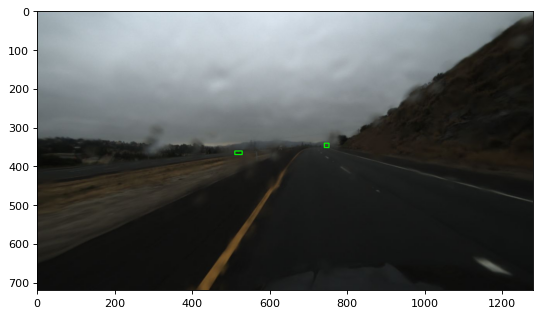

In [ ]:
CLIP_NO = 5057

fd = open(f"{test_supp}{CLIP_NO}.json")
f = json.load(fd)
fdvs = open(VELO_SUPP + "annotation.json")
fvs = json.load(fdvs)
im = cv2.imread(VELO_SUPP + f"supp_img/{str(CLIP_NO).zfill(4)}.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
print(f)
for bbs in f[str(CLIP_NO)]:
    c1 = int(bbs["left"]), int(bbs["top"])
    c2 = int(bbs["right"]), int(bbs["bottom"])
    cv2.rectangle(im,c1,c2,(0,0,255),5)
for bbs in fvs[CLIP_NO-1]["bbox"]:
    c1 = int(bbs["left"]), int(bbs["top"])
    c2 = int(bbs["right"]), int(bbs["bottom"])
    cv2.rectangle(im,c1,c2,(0,255,0),2)
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(im)
